In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import librosa

import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_emotion(filename):
    emotions = ["ANG","SAD","FEA","NEU","HAP","DIS"]
    for emotion in emotions:
        if emotion in filename:
            return emotion
    print(f"WARNING: No emotion found in {filename}")
    return None  # Will be filtered later


In [3]:
audio_extensions = ['.wav', '.mp3', '.flac', '.ogg']  # Add your file formats
training_files = [f for f in os.listdir('data') 
                 if os.path.splitext(f)[1].lower() in audio_extensions]
paths = []
labels = []
for filename in training_files:
    path = os.path.join('data', filename)
    if not os.path.exists(path):  # Extra safeguard
        continue
    label = extract_emotion(filename)
    if label is None:  # Handle files without emotion tags
        continue
    paths.append(path)
    labels.append(label)
    

In [4]:
df = pd.DataFrame()
df['path'] = paths
df['labels'] = labels
df.head(5)

,path,labels
0,data/139_SAD.wav,SAD
1,data/1124_FEA.wav,FEA
2,data/347_ANG.wav,ANG
3,data/1697_ANG.wav,ANG
4,data/1591_SAD.wav,SAD


In [5]:
emotions = ["ANG", "SAD", "FEA", "NEU", "HAP", "DIS"]

# Map from emotion string to integer
emotion_to_idx = {emotion: idx for idx, emotion in enumerate(emotions)}

# Inverse map from integer to emotion string
idx_to_emotion = {idx: emotion for idx, emotion in enumerate(emotions)}

print(emotion_to_idx)
print(idx_to_emotion)


{'ANG': 0, 'SAD': 1, 'FEA': 2, 'NEU': 3, 'HAP': 4, 'DIS': 5}
{0: 'ANG', 1: 'SAD', 2: 'FEA', 3: 'NEU', 4: 'HAP', 5: 'DIS'}


In [6]:
df = df[df['path'].apply(os.path.exists)]


In [8]:
df.shape

(9053, 2)

In [7]:
df['labels'] = df['labels'].map(emotion_to_idx)
df.head(5)

print("Label value counts:")
print(df['labels'].value_counts())

# Remove invalid labels
df = df.dropna(subset=['labels'])
df['labels'] = df['labels'].astype(int)

print(df.shape)
df.head(10)

Label value counts:
labels
1    1555
0    1546
5    1532
4    1530
2    1518
3    1372
Name: count, dtype: int64
(9053, 2)


,path,labels
0,data/139_SAD.wav,1
1,data/1124_FEA.wav,2
2,data/347_ANG.wav,0
3,data/1697_ANG.wav,0
4,data/1591_SAD.wav,1
5,data/1692_NEU.wav,3
6,data/777_DIS.wav,5
7,data/1134_FEA.wav,2
8,data/129_SAD.wav,1
9,data/1687_ANG.wav,0


In [8]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=5*(16000)):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['labels']

        # Ensure label is valid
        if not isinstance(label, (int, np.integer)) or label < 0 or label >= len(emotions):
            print(f"Invalid label {label} in {audio_path}")
            return self.__getitem__((idx + 1) % len(self))  # Skip bad sample
    
        try:
            speech, sr = librosa.load(audio_path, sr=16000)
        except Exception as e:
            print(f"Error loading {audio_path}: {str(e)}")
            # Return random data or skip this sample
            speech = np.zeros(self.max_length)
    
        # Pad or truncate speech to max length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')
        
        # Use the processor to tokenize and create attention mask
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length, return_attention_mask=True)
        
        input_values = inputs.input_values.squeeze()
        attention_mask = inputs.attention_mask.squeeze()
        
        return {
            'input_values': input_values,
            'attention_mask': attention_mask,  # Include attention mask
            'labels': torch.tensor(int(label), dtype=torch.long)  # Explicit conversion
        }


In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [10]:
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('results/checkpoint-6342')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [11]:
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [14]:
train_dataset[0]

Keyword argument `truncate` is not a valid argument for this processor and will be ignored.


{'input_values': tensor([ 0.0026, -0.0010, -0.0016,  ...,  0.0003,  0.0003,  0.0003]),
 'labels': tensor(5)}

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle = True)

In [15]:
train_args = TrainingArguments(
    output_dir = './results_1',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 5e-5,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 5,
    weight_decay = 0.01,
    report_to = []
    
)

In [16]:
from sklearn.metrics import accuracy_score , adjusted_rand_score

def compute_metrics(pred):
    labels = pred.label_ids  # true labels
    preds = np.argmax(pred.predictions, axis=1)  # predicted labels
    
    accuracy = accuracy_score(labels, preds)
    ari = adjusted_rand_score(labels , preds)
    
    return {
        "accuracy": accuracy,
        "ari": ari
    }
    


In [17]:
trainer = Trainer(
    model = model,
    args = train_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

Python(85060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(85061) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch,Training Loss,Validation Loss


In [20]:
import os
import pandas as pd
import numpy as np
import librosa
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# Load trained model and processor (2-second audio processing)
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('results/checkpoint-6342')
model.eval()

# Configure test directory
test_folder = 'test'
emotions = ["ANG", "SAD", "FEA", "NEU", "HAP", "DIS"]

# Process all WAV files
results = []
for filename in [f for f in os.listdir(test_folder) if f.endswith('.wav')]:
    try:
        speech, _ = librosa.load(os.path.join(test_folder, filename), sr=16000)
    
        # 1. Truncate FIRST to prevent negative padding
        truncated = speech[:32000]  # Exact 2-second truncation
    
        # 2. Calculate padding using TRUNCATED length
        padding_needed = 32000 - len(truncated)
    
        # 3. Apply padding only if needed
        if padding_needed > 0:
            speech = np.pad(truncated, (0, padding_needed), 'constant')
        else:
            speech = truncated  # No padding needed
        
        # Model prediction
        inputs = processor(speech, return_tensors='pt', sampling_rate=16000)
        with torch.no_grad():
            logits = model(**inputs).logits
        
        # Store results
        results.append({
            'filename': filename,
            'emotion': emotions[torch.argmax(logits).item()]
        })
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")


# Save predictions
pd.DataFrame(results).to_csv('w2v2_ep6_ft.csv', index=False)
print(f"Saved {len(results)} predictions to predictions.csv")


Saved 2764 predictions to predictions.csv


<Figure size 800x600 with 0 Axes>

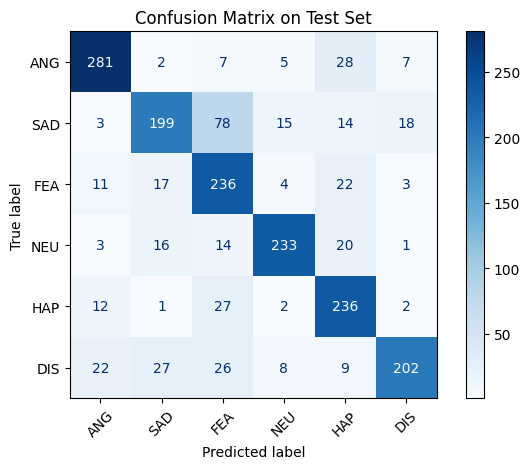

In [23]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('results/checkpoint-6342')

# Set model to evaluation mode
model.eval()

# Initialize lists to collect true and predicted labels
true_labels = []
pred_labels = []

# Disable gradient computation
with torch.no_grad():
    for batch in test_dataloader:
        # Move inputs, labels, and attention_mask to the same device as model
        input_values = batch['input_values'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        # Forward pass
        outputs = model(input_values=input_values, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Collect labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())

# Define emotion labels (order must match model output indices)
emotions = ["ANG", "SAD", "FEA", "NEU", "HAP", "DIS"]

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()
